# Aprendiendo Redes Neuronales

En este notebook, realizamos una primera aproximación a las redes neuronales. Vamos a usarlas para resolver un problema sencillo de clasificación donde deberemos clasificar dos anillos concéntricos.

Vamos a implementar las redes neuronales desde el nivel más bajo de abstracción al nivel más alto:

+ Python: implementamos desde cero las redes neuronales, "picando" el código necesario para crear la estructura de datos que almacena la red neuronal y las funciones para entrenarla.

+ Tensorflow: subimos un escalón en el nivel de abstracción. Con la librería Tensorflow, no tendremos que crearnos la estructura de datos de la red neuronal. Más bien, tenemos describir cada una de las capas con gran capacidad de detalle. Donde más ventaja tenemos es a la hora de entrenarla, pues lo hace automáticamente y de forma optimizada. 

+ Keras: nivel intermedio de abstracción. Donde notamos la diferencia con Tensorflow es que es más sencillo configurar las capas. A cambio, perdemos un poco de capacidad de detalle.

+ Sklearn: llegamos al último nivel. Simplemente tenemos varios modelos de redes neuronales de entre los que podemos elegir. La dificultad reside en conseguir la combinación de parámetros más conveniente. No tenemos apenas capacidad de detalle a la hora de configurar la red neuronal.

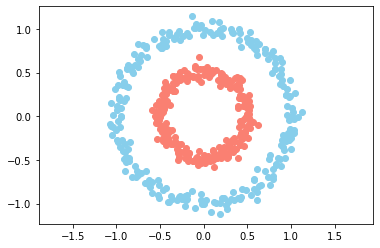

In [96]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

#Creamos el dataset. El problema tratara de clasificar dos anillos concentricos
X, Y = make_circles(n_samples = 500, factor = 0.5, noise = 0.05)
Y = Y[:, np.newaxis]

#Visualizamos el dataset para aclarar cual es nuestro objetivo
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c = "skyblue")
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c = "salmon")
plt.axis("equal")
plt.show()

In [97]:
from matplotlib import animation
from IPython.core.display import display, HTML #Ojo: para crear la animacion debemos tener instalado ffmpeg

#Funcion para generar la animacion del entrenamiento (su ejecucion puede tardar varios segundos)
def generateTrainingAnimation(X, Y, iPY):
    print('--- Generando animacion ---')
    res = 50 #Resolución del mapa de prediccion
    _x0 = np.linspace(-1.5, 1.5, res) #Coordenadas del mapa de prediccion
    _x1 = np.linspace(-1.5, 1.5, res)
    _pX = np.array(np.meshgrid(_x0, _x1)).T.reshape(-1, 2) #Input con cada combo de coordenadas del mapa de prediccion.
    _pY = np.zeros((res, res)) + 0.5 #Objeto vacio a 0.5 del mapa de predicción
    
    #No explicamos el siguiente codigo porque no es de interes
    ims = []
    fig = plt.figure(figsize=(10, 10))

    for frame in range(len(iPY)):
        im = plt.pcolormesh(_x0, _x1, iPY[frame], cmap="coolwarm", animated=True)

        # Visualización de la nube de datos
        auxY = Y.ravel()
        plt.scatter(X[auxY == 0,0], X[auxY == 0,1], c="skyblue")
        plt.scatter(X[auxY == 1,0], X[auxY == 1,1], c="salmon")
        plt.tick_params(labelbottom=False, labelleft=False)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    return HTML(ani.to_html5_video())

## Python

In [98]:
#Clase que representa una capa de la red neuronal. Para cada capa tenemos: una funcion de activación, un vector de bias 
#con tantas componentes como neuronas tenga la capa y una matriz de pesos de dimensiones conexiones x neuronas.
class neuralLayer():
        def __init__(self, connectionsNumber, neuronsNumber, activationFunction):
            self.activationFunction = activationFunction
            self.b = np.random.rand(1, neuronsNumber) * 2 - 1
            self.W = np.random.rand(connectionsNumber, neuronsNumber) * 2 - 1

In [99]:
#Funciones de activacion
#Describimos a cada funcion de activacion como una tupla, en donde su primera componente es la propia funcion y la
#segunda componente es su derivada.

sigmoide = (lambda x : 1 / (1 + np.e ** (-x)), 
            lambda x : x * (1 - x))

relu = lambda x : np.maximum(0, x)

meanSquareError = (lambda YPredicted, YReal : np.mean((YPredicted - YReal)**2),  
                   lambda YPredicted, YReal : (YPredicted - YReal))

#Funcion encargada de crear una red neuronal, dada su topologia y su funcion de activacion.
#Describimos la red neuronal como un vector de capas, donde cada capa es la clase creada anteriormente.
def createNeuralNetwork(topology, activationFunction) :
    neuralNetwork = []
    for i, layer in enumerate(topology[:-1]):
        neuralNetwork.append(neuralLayer(topology[i], topology[i+1], activationFunction))
    return neuralNetwork

#Funcion encargada de entrenar a la red neuronal.
#Tambien podemos usarla para solamente predecir poniendo el parametro train a False
def trainNeuralNetwork(neuralNetwork, X, Y, costFunction, learningRate = 0.5, train = True) :
    output = [(None, X)]
    
    #Forward pass (predecimos el resultado para cada dato de entrenamiento)
    for i, layer in enumerate(neuralNetwork):
        z = output[-1][1] @ neuralNetwork[i].W + neuralNetwork[i].b
        a = neuralNetwork[i].activationFunction[0](z)
        output.append((z, a))
    
    if train:
        #Backward pass (calculamos en orden inverso las derivadas parciales de cada capa)
        deltas = []
        
        for i in reversed(range(0, len(neuralNetwork))):
            z = output[i+1][0]
            a = output[i+1][1]
            
            if i == len(neuralNetwork) - 1:
                #Calcular delta ultima capa
                deltas.insert(0, costFunction[1](a, Y) * neuralNetwork[i].activationFunction[1](a))
            else:
                #Calcular delta respecto a capa previa
                deltas.insert(0, deltas[0] @ _W.T * neuralNetwork[i].activationFunction[1](a))
            
            _W = neuralNetwork[i].W
            
            #Gradient descent (aplicamos el algoritmo de descenso de gradiente en cada capa)
            neuralNetwork[i].b = neuralNetwork[i].b - np.mean(deltas[0], axis=0, keepdims=True) * learningRate
            neuralNetwork[i].W = neuralNetwork[i].W - output[i][1].T @ deltas[0] * learningRate
    
    return output[-1][1]

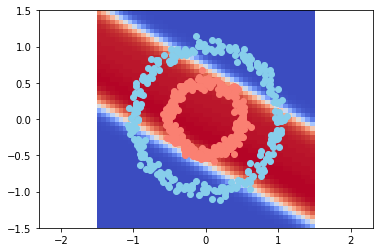

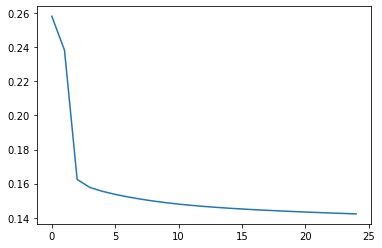

In [100]:
import time
from IPython.display import clear_output

topology = [2, 4, 8, 1] #Topologia de la red neuronal: describimos el número de neuronas por capa
learningRate = 0.025 #Learning rate del optimizador (normalmente descenso del gradiente)
neuralNetwork = createNeuralNetwork(topology, sigmoide) #Creamos la red neuronal
loss = []
nSteps = 2500

for i in range(nSteps):
    
    #Entrenamos la red
    pY = trainNeuralNetwork(neuralNetwork, X, Y, meanSquareError, learningRate = 0.05)
    
    if i % 100 == 0:
        loss.append(meanSquareError[0](pY, Y))
        res = 50
        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)
        
        _Y = np.zeros((res, res))
        
        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _Y[i0, i1] = trainNeuralNetwork(neuralNetwork, np.array([[x0, x1]]), Y, meanSquareError, train=False)[0][0]
                
        plt.pcolormesh(_x0, _x1, _Y, cmap = "coolwarm")
        plt.axis("equal")
        
        plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c = "skyblue")
        plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c = "salmon")
        
        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.show()
        time.sleep(0.25)

## Tensorflow

In [101]:
import tensorflow as tf

topology = [2, 16, 8, 1]
learningRate = 0.025

#Definimos los placeholders: puntos de entrada de datos de nuestra red
iX = tf.placeholder('float', shape = [None, X.shape[1]])
iY = tf.placeholder('float', shape = [None])

#Capa 1
W1 = tf.Variable(tf.random_normal([topology[0], topology[1]]), name = 'Weights_1')
b1 = tf.Variable(tf.random_normal([topology[1]]), name = 'bias_1')

l1 = tf.nn.relu(tf.add(tf.matmul(iX, W1), b1))

#Capa 2
W2 = tf.Variable(tf.random_normal([topology[1], topology[2]]), name = 'Weights_2')
b2 = tf.Variable(tf.random_normal([topology[2]]), name = 'bias_2')

l2 = tf.nn.relu(tf.add(tf.matmul(l1, W2), b2))

#Capa 3
W3 = tf.Variable(tf.random_normal([topology[2], topology[3]]), name = 'Weights_3')
b3 = tf.Variable(tf.random_normal([topology[3]]), name = 'bias_3')

pY = tf.nn.sigmoid(tf.add(tf.matmul(l2, W3), b3))[:, 0] #Vector predicciones de Y

#Entrenamos la red neuronal
loss = tf.losses.mean_squared_error(pY, iY) #Evaluacion de las predicciones
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learningRate).minimize(loss) #Optimizador que entrenara a la red
nSteps = 2500 #Numero de pasos para entrenar a la red
iPY = [] #Vector que guardara la evolucion de las predicciones para crear la animacion.

with tf.Session() as sess:
    auxY = Y.ravel()
    sess.run(tf.global_variables_initializer())
    for step in range(nSteps):  
        _, _loss, _pY = sess.run([optimizer, loss, pY], feed_dict = {iX : X, iY : auxY})
        
        # Imprimimos métricas
        if step % 25 == 0: 
            # Cálculo del accuracy.
            acc = np.mean(np.round(_pY) == auxY)

            # Impresión de métricas.
            print('Step', step, '/', nSteps, '- Loss = ', _loss, '- Acc =', acc)

            # Obtenemos predicciones para cada punto de nuestro mapa de predicción _pX.
            _pY = sess.run(pY, feed_dict={ iX : _pX }).reshape((res, res))

            # Y lo guardamos para visualizar la animación.
            iPY.append(_pY)


Step 0 / 2500 - Loss =  0.3245601 - Acc = 0.622
Step 25 / 2500 - Loss =  0.2689421 - Acc = 0.686
Step 50 / 2500 - Loss =  0.2503403 - Acc = 0.756
Step 75 / 2500 - Loss =  0.24305741 - Acc = 0.766
Step 100 / 2500 - Loss =  0.23704755 - Acc = 0.766
Step 125 / 2500 - Loss =  0.23171893 - Acc = 0.774
Step 150 / 2500 - Loss =  0.2267414 - Acc = 0.776
Step 175 / 2500 - Loss =  0.2219157 - Acc = 0.78
Step 200 / 2500 - Loss =  0.21721949 - Acc = 0.782
Step 225 / 2500 - Loss =  0.21254492 - Acc = 0.784
Step 250 / 2500 - Loss =  0.2077441 - Acc = 0.784
Step 275 / 2500 - Loss =  0.2027474 - Acc = 0.794
Step 300 / 2500 - Loss =  0.19733237 - Acc = 0.798
Step 325 / 2500 - Loss =  0.19131458 - Acc = 0.802
Step 350 / 2500 - Loss =  0.18474591 - Acc = 0.808
Step 375 / 2500 - Loss =  0.17782746 - Acc = 0.814
Step 400 / 2500 - Loss =  0.17042115 - Acc = 0.822
Step 425 / 2500 - Loss =  0.16243036 - Acc = 0.822
Step 450 / 2500 - Loss =  0.15397634 - Acc = 0.822
Step 475 / 2500 - Loss =  0.14534652 - Acc =

--- Generando animacion ---


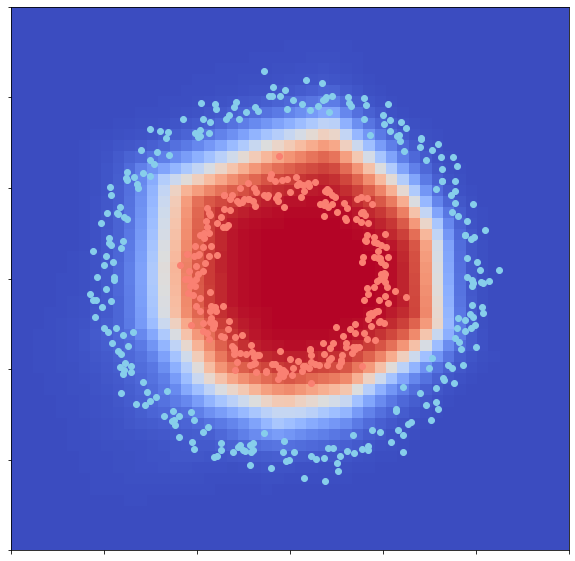

In [102]:
generateTrainingAnimation(X, Y, iPY)

## Keras

In [103]:
import tensorflow.keras as kr

learningRate = 0.025
nnTopology = [2, 16, 8, 1]

model = kr.Sequential() #Estructura que contiene nuestro modelo

#Capa 1
model.add(kr.layers.Dense(nnTopology[1], activation = 'relu'))

#Capa 2
model.add(kr.layers.Dense(nnTopology[2], activation = 'relu'))

#Capa 3
model.add(kr.layers.Dense(nnTopology[3], activation = 'sigmoid'))

#Compilamos el modelo
model.compile(loss = 'mse', optimizer = kr.optimizers.SGD(lr = learningRate), metrics = ['acc'])

#Entrenamos el modelo
model.fit(X, Y, epochs = 500, verbose = 1)


Epoch 1/500
500/500 [==============================] - 0s 585us/sample - loss: 0.2545 - acc: 0.4920
Epoch 2/500
500/500 [==============================] - 0s 52us/sample - loss: 0.2540 - acc: 0.4960
Epoch 3/500
500/500 [==============================] - 0s 62us/sample - loss: 0.2534 - acc: 0.4840
Epoch 4/500
500/500 [==============================] - 0s 56us/sample - loss: 0.2529 - acc: 0.4880
Epoch 5/500
500/500 [==============================] - 0s 63us/sample - loss: 0.2524 - acc: 0.4920
Epoch 6/500
500/500 [==============================] - 0s 62us/sample - loss: 0.2519 - acc: 0.4880
Epoch 7/500
500/500 [==============================] - 0s 54us/sample - loss: 0.2514 - acc: 0.4840
Epoch 8/500
500/500 [==============================] - 0s 66us/sample - loss: 0.2510 - acc: 0.4900
Epoch 9/500
500/500 [==============================] - 0s 72us/sample - loss: 0.2506 - acc: 0.4800
Epoch 10/500
500/500 [==============================] - 0s 64us/sample - loss: 0.2502 - acc: 0.4860
Epoch 11

500/500 [==============================] - 0s 52us/sample - loss: 0.1793 - acc: 0.9240
Epoch 83/500
500/500 [==============================] - 0s 45us/sample - loss: 0.1776 - acc: 0.9260
Epoch 84/500
500/500 [==============================] - 0s 46us/sample - loss: 0.1759 - acc: 0.9280
Epoch 85/500
500/500 [==============================] - 0s 56us/sample - loss: 0.1742 - acc: 0.9280
Epoch 86/500
500/500 [==============================] - 0s 68us/sample - loss: 0.1725 - acc: 0.9280
Epoch 87/500
500/500 [==============================] - 0s 68us/sample - loss: 0.1707 - acc: 0.9280
Epoch 88/500
500/500 [==============================] - 0s 84us/sample - loss: 0.1689 - acc: 0.9300
Epoch 89/500
500/500 [==============================] - 0s 67us/sample - loss: 0.1671 - acc: 0.9320
Epoch 90/500
500/500 [==============================] - 0s 69us/sample - loss: 0.1653 - acc: 0.9320
Epoch 91/500
500/500 [==============================] - 0s 56us/sample - loss: 0.1633 - acc: 0.9320
Epoch 92/500


500/500 [==============================] - 0s 48us/sample - loss: 0.0341 - acc: 1.0000
Epoch 164/500
500/500 [==============================] - 0s 42us/sample - loss: 0.0334 - acc: 1.0000
Epoch 165/500
500/500 [==============================] - 0s 45us/sample - loss: 0.0327 - acc: 1.0000
Epoch 166/500
500/500 [==============================] - 0s 41us/sample - loss: 0.0321 - acc: 1.0000
Epoch 167/500
500/500 [==============================] - 0s 39us/sample - loss: 0.0314 - acc: 1.0000
Epoch 168/500
500/500 [==============================] - 0s 41us/sample - loss: 0.0307 - acc: 1.0000
Epoch 169/500
500/500 [==============================] - 0s 43us/sample - loss: 0.0301 - acc: 1.0000
Epoch 170/500
500/500 [==============================] - 0s 41us/sample - loss: 0.0295 - acc: 1.0000
Epoch 171/500
500/500 [==============================] - 0s 41us/sample - loss: 0.0289 - acc: 1.0000
Epoch 172/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0283 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 42us/sample - loss: 0.0092 - acc: 1.0000
Epoch 245/500
500/500 [==============================] - 0s 42us/sample - loss: 0.0091 - acc: 1.0000
Epoch 246/500
500/500 [==============================] - 0s 35us/sample - loss: 0.0090 - acc: 1.0000
Epoch 247/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0089 - acc: 1.0000
Epoch 248/500
500/500 [==============================] - 0s 40us/sample - loss: 0.0088 - acc: 1.0000
Epoch 249/500
500/500 [==============================] - 0s 39us/sample - loss: 0.0087 - acc: 1.0000
Epoch 250/500
500/500 [==============================] - 0s 37us/sample - loss: 0.0086 - acc: 1.0000
Epoch 251/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0085 - acc: 1.0000
Epoch 252/500
500/500 [==============================] - 0s 40us/sample - loss: 0.0084 - acc: 1.0000
Epoch 253/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0083 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 38us/sample - loss: 0.0045 - acc: 1.0000
Epoch 326/500
500/500 [==============================] - 0s 44us/sample - loss: 0.0045 - acc: 1.0000
Epoch 327/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0044 - acc: 1.0000
Epoch 328/500
500/500 [==============================] - 0s 34us/sample - loss: 0.0044 - acc: 1.0000
Epoch 329/500
500/500 [==============================] - 0s 40us/sample - loss: 0.0044 - acc: 1.0000
Epoch 330/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0044 - acc: 1.0000
Epoch 331/500
500/500 [==============================] - 0s 35us/sample - loss: 0.0043 - acc: 1.0000
Epoch 332/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0043 - acc: 1.0000
Epoch 333/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0043 - acc: 1.0000
Epoch 334/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0042 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 39us/sample - loss: 0.0028 - acc: 1.0000
Epoch 407/500
500/500 [==============================] - 0s 39us/sample - loss: 0.0028 - acc: 1.0000
Epoch 408/500
500/500 [==============================] - 0s 42us/sample - loss: 0.0028 - acc: 1.0000
Epoch 409/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0028 - acc: 1.0000
Epoch 410/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0028 - acc: 1.0000
Epoch 411/500
500/500 [==============================] - 0s 34us/sample - loss: 0.0028 - acc: 1.0000
Epoch 412/500
500/500 [==============================] - 0s 39us/sample - loss: 0.0028 - acc: 1.0000
Epoch 413/500
500/500 [==============================] - 0s 38us/sample - loss: 0.0027 - acc: 1.0000
Epoch 414/500
500/500 [==============================] - 0s 34us/sample - loss: 0.0027 - acc: 1.0000
Epoch 415/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0027 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 38us/sample - loss: 0.0020 - acc: 1.0000
Epoch 488/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0020 - acc: 1.0000
Epoch 489/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0020 - acc: 1.0000
Epoch 490/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0020 - acc: 1.0000
Epoch 491/500
500/500 [==============================] - 0s 33us/sample - loss: 0.0020 - acc: 1.0000
Epoch 492/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0020 - acc: 1.0000
Epoch 493/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0020 - acc: 1.0000
Epoch 494/500
500/500 [==============================] - 0s 39us/sample - loss: 0.0020 - acc: 1.0000
Epoch 495/500
500/500 [==============================] - 0s 35us/sample - loss: 0.0020 - acc: 1.0000
Epoch 496/500
500/500 [==============================] - 0s 34us/sample - loss: 0.0019 - acc: 1.0000
Epoc

## Sklearn

In [111]:
import sklearn as sk
import sklearn.neural_network

learningRate = 0.025
topology = [2, 16, 8, 1]

model = sk.neural_network.MLPRegressor(solver = 'sgd',
                                       learning_rate_init = learningRate,
                                       hidden_layer_sizes = topology[1:],
                                       verbose = True,
                                       n_iter_no_change = 1000)

model.fit(X, Y.ravel()) #Entrenamos el modelo

Iteration 1, loss = 0.28866932
Iteration 2, loss = 0.17149895
Iteration 3, loss = 0.12389637
Iteration 4, loss = 0.12014702
Iteration 5, loss = 0.11237298
Iteration 6, loss = 0.10354037
Iteration 7, loss = 0.09519294
Iteration 8, loss = 0.08775784
Iteration 9, loss = 0.08055416
Iteration 10, loss = 0.07423202
Iteration 11, loss = 0.06923171
Iteration 12, loss = 0.06451100
Iteration 13, loss = 0.06019077
Iteration 14, loss = 0.05520268
Iteration 15, loss = 0.05050744
Iteration 16, loss = 0.04589413
Iteration 17, loss = 0.04140113
Iteration 18, loss = 0.03614118
Iteration 19, loss = 0.03136645
Iteration 20, loss = 0.02692839
Iteration 21, loss = 0.02268404
Iteration 22, loss = 0.01887109
Iteration 23, loss = 0.01557259
Iteration 24, loss = 0.01324088
Iteration 25, loss = 0.01125206
Iteration 26, loss = 0.01007845
Iteration 27, loss = 0.00927500
Iteration 28, loss = 0.00886945
Iteration 29, loss = 0.00857580
Iteration 30, loss = 0.00854489
Iteration 31, loss = 0.00819349
Iteration 32, los

D:\Programas\Anaconda3\envs\InformaticaTFG\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=[16, 8, 1], learning_rate_init=0.025,
             n_iter_no_change=1000, solver='sgd', verbose=True)

## Conclusiones

Podemos ver como, según vamos aumentando el nivel de abstracción, reducimos las líneas de código necesarias para crear y entrenar la red. Sin embargo, vamos perdiendo cada vez más capacidad de configurar nuestra red y reducimos el nivel de detalle al que podemos acceder.

Como "picar" todos los métodos necesarios para la red neuronal sería demasiado trabajo vamos a usar las librerías disponibles. Sklearn es quizás es de demasiado nivel de abstracción, lo cual está bien para aprender. Por ello, nos situaremos en un nivel intermedio entre Keras y Tensorflow, usando principalmente Keras pero "bajando" a Tensorflow cuando sea necesario.